# JPEG Analysis
## An in-depth look at the JPEG File Interchange Format with Python3
#### Skyler Rankin 2019
##### *Version 0.1*

### Introduction
This notebook attempts to explore the mechanisms at play behind one of the most widely used image file formats. In short, by parsing the file byte by byte, and using a specification reference, we can interpret all of the information stored in the file, and even generate the corresponding image without a pre-built image viewer. The primary reference used will be the report given by Ecma-Internation found [here](https://www.ecma-international.org/publications/files/ECMA-TR/ECMA%20TR-098.pdf).

### Table of Contents
#### [Section 1](#1) | Importing an Image
#### [Section 2](#2) | Basic JPEG Structure
#### [Section 3](#3) | Parsing Segments: Part 1
#### [Section 4](#4) | Huffman Encoding


### Section 1: Importing an Image<a name="1"></a>
First, we must select an image to work with. I have included a small default image with this repository for testing, but feel free to add your own by adding the file to the project root and changing the filename in the code below.

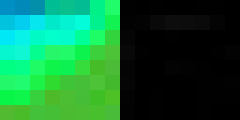

In [2]:
from IPython.display import Image
image_filename = "image_no_meta.jpg"
Image("image_scaled.jpg", width=200)

### Section 2: Basic JPEG Structure<a name="2"></a>
The structure of a JPEG file relies upon a system of **markers**. These are specific 2-byte sequences that are reserved for a specific purpose, so that when you see one in the file, you can be sure of its meaning. For convenience, I will represent these byte sequences as hex values preceeded by `0x`, meaning the decimal number `78` is represented as `1001110` as binary in the image file, but is written as `0x4E` in hex for our purposes. In the JPEG File Format, all markers are preceeded by `0xFF`, which makes the marker two bytes in total.
The first markers to look for are the **SOI** and **EOI** markers. These signify **start of image** and **end of image** respectively.

Marker | Value
--- | --- 
SOI | 0xFFD8
EOI | 0xFFD9

We can be sure that no important information for the image will come before the `SOI` marker, and no information will come after the `EOI`. The information between these markers can be referred to as a segment. A common idea for structuring segments is using a **header**. A header is a small sequence of bytes at the beginning of a segment that describe what that segment contains. The specifics for the headers are dependent on the marker type, but we will see many of these headers as we parse the image file. An example of this is the `SOF0` marker, which denotes the **start of frame 0**. This segment uses the marker `0xC0` and contains information regarding the image data. The specifics of extracting information from headers will come in the next section.

Before we can parse these headers and segments, it helps to define a function to convert the bytes read from the file as Python `byte` objects into pure integers. This makes storing and manipulating their values simpler later on. The following function `hti`, "Hex To Integer", does just that: takes in a byte and returns the integer representation.

In [3]:
def hti(h):
    return int.from_bytes(h, byteorder='big')

print("Hex value 0xD8 converted with function: ",hti(b'\xD8'))
print("Actual integer value: ",16*13+8)

Hex value 0xD8 converted with function:  216
Actual integer value:  216


In [19]:
markers = {
        0xFFD8: "SOI",
        0xFFE0: "APP0",
        0xFFC0: "SOF0",
        0xFFC4: "DHT",
        0xFFDB: "DQT",
        0xFFDA: "SOS",
        0xFFD9: "EOI",
    }
for i in range(17):
    markers[(0xFFE0+i)] = "APP{}".format(i)

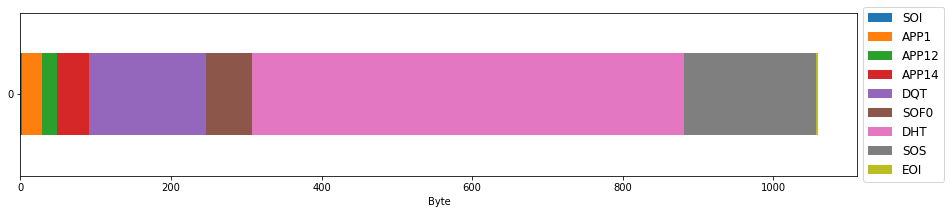

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

file = open(image_filename, "rb")
segments = [[],[]]
s = 0
for i in range(10):
    byte = (file.read(1), file.read(1))
    s+=2
    while hti(byte[0]+byte[1]) not in markers.keys():
        byte = (byte[1], file.read(1))
        s+=1
    segments[0].append(byte[0]+byte[1])
    if len(segments[0]) > 1 and len(segments[1]) > 0:
        segments[1].append(s-2-segments[1][-1])
    elif len(segments[0]) > 1:
        segments[1].append(s-2)
    if hti(byte[0]+byte[1]) == 65497:
        break
segments[1].append(2)

df = pd.DataFrame([segments[1]], columns=[markers[hti(x)] for x in segments[0]])
df.plot.barh(stacked=True, figsize=(15, 3))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize="large")
plt.xlabel("Byte")
file.close()

### Section 3: Parsing Segments Part 1<a name="3"></a>

The general structure I will use to parse segments is defining a function for each of the segments we want to parse. These functions will take in the file we are reading as the argument `file`. An important function that will be repeatedly used is `read`. This function takes in an integer representing the number of bytes to read and return from the given file object. So when we type `file.read(2)`, we read the next two bytes from the file and return that 2 byte value. Afterwards, I will always use my function previously defined, `hti`, to convert those bytes into an integer.

For all segments, the data of that segment starts immediately after the segment marker. So as soon as our program reads `0xFFC0`, the marker for SOFO, we can call the function to parse SOFO, and any subsequent calls to read will be reading the bytes that are next in the file.

##### Start of Frame Parsing

As mentioned, the first segment we will write code to parse is the **start of frame** segment. According to the documentation, the first 2 bytes of a SOFO segment denote the length of the segment. That's easy enough to handle: we store that value into a variable called `length`, as seen on line `3`. After that come the precision, height, width, and number of components. We store all of those in the same fashion.

While pieces of information like width and height are simple to read, since they are of fixed length, other data is a little trickier. The first variable length information we will see is the `components` data within the SOFO segment. This is a list of image components, each containing 3 bytes:
1. ID - Which part of the YCrCb color space this component holds
2. Sampling Factor - This is used later on
3. Quantization Table - The ID of the quantization table to be used

This piece of information is variable length because there could be 1 component, or there could be 3, or some other value: we don't know for every image how many there will be. As such, we cannot hard-code calls to `read`. Instead, we will use the provided `length` value. Consider **Figure 3.1** below. The first yellow block denotes the 2 byte marker `0xFFC0`. All green blocks represent some piece of information we will read. The light green block is the block of variable length.
<img src="images/4.1.jpg">
The first value in the segment is the `length`, which is a 2 byte value, so it makes up bytes 3 and 4. Let's assume that after reading those 2 bytes, we saw `length=17`. Following the documentation, byte 5 will be the data precision, bytes 6 and 7 are the height, 8 and 9 are the width, and byte 10 is the number of components. Let's say the number of components read was `3`.

Since each component contains 3 bytes, we know that there will be `9` total bytes we need to read to get all 3 components. Furthermore, since the first 5 pieces of information took 8 bytes and the components took 9 bytes, that makes 17 bytes total. This matches the `length` value exactly.

With that understanding out of the way, we can look at the function itself. As mentioned, we take in a reference to the file. The function then reads all of the fixed length variables and stores them. It loops over the the number of components, adding them to an array. Finally, it returns a dictionary that maps the names of the values to the data we got from that segment.

In [6]:
def parse_SOF0(file):
    #length = 8 + (#components * 3)
    length = hti(file.read(2))
    #bits/sample
    precision = hti(file.read(1))
    height = hti(file.read(2))
    width = hti(file.read(2))
    #1 = grey scale, 3 = YCbCr, 4 = CMYK
    num_components = hti(file.read(1))
    components = []
    for i in range(int((length - 8) / 3)):
        #1 = Y, 2 = Cb, 3 = Cr, 4 = I, 5 = Q
        component_id = hti(file.read(1))
        sampling_factor = hti(file.read(1))
        q_table = hti(file.read(1))
        components.append({
            "id": component_id,
            "sampling_factor": sampling_factor,
            "q_table": q_table
        })
    return {
        "length": length,
        "precision": precision,
        "height": height,
        "width": width,
        "num_components": num_components,
        "components": components
    }

Notice that there is some further information we can extract from these values. Since the number of components denotes how many color spaces we need to display the image, it is clear that if there is only 1, we are parsing a purely gray-scale image. If there are 3 components, then we are dealing with the common YCbCr system: more on this later.

##### Define Quantization Table Parsing

The next segment we will tackle is the **DQT** segment. This segment contains the values for a quantization table which will later be used for decoding image data. These tables are basically 8x8 matrices of integers. As with the SOFO segment, the first piece of information is a length value, which is again 2 bytes. After the length, there is a single information byte for the quantization table. Last is the table itself, which contains `64` values if the precision is 0 (8 bit) and `128` values if the precision is 1 (16 bit). What's tricky here is that a segment may contain multiple quantization tables, each with a single information bit and a series of values. Thus, the only way to tell how many tables you have is to use the `length` value while parsing. Consider **Figure 4.2** below.
<img src="images/4.2.jpg">
The yellow block denotes the segment marker `0xFFDB`. After that, we can see the 2 byte length value, bytes 3 and 4. Let's assume that this value was 132.
After the length, we enter a light green block, which contains a quantization table. We first read byte 5, the information byte of a table. Afterwards, we read the 64 values for that table, bytes 6 through 69.
At this point, from the tables alone we would not know if we had completed the segment. But since the total length was 132, and we had read 2 bytes for the length itself plus 65 bytes for the first table, there are `132 - 2 - 65 > 0` some number of bytes remaining. So we continue, assuming that there will be at least 1 more complete table to read. Again, reading 1 information bit, byte 70, and 64 values, bytes 71 through 134, giving us our second quantization table from this segment. At this point, `132` bytes have been read, so the segment is completed.


Should be doing zip zag to revert to the original form.
Is it always symmetrical?

In [169]:
def reverse_zigzag(m):
    pos = (0, 0) #row, col
    d = "up"
    r = np.zeros((len(m), len(m)))
    for n in m.flatten():
        r[pos[0], pos[1]] = n        
        if d == "up":
            if pos[0] == 0: #going up, hit the top
                d = "down"
                if pos[1] == len(m)-1: #hit the top/right corner
                    pos = (pos[0]+1, pos[1])
                else: #hit the top when going up
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == len(m)-1: #hit the right side when going up
                d = "down"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in middle
                pos = (pos[0]-1, pos[1]+1)
        else: #going down
            if pos[0] == len(m)-1: #hit the bottom
                d = "up"
                if pos[0] == 0: #hit the bottom/left corner
                    pos = (pos[0], pos[1]+1)
                else: #hit bottom
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == 0: #hit the left side
                d = "up"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in the middle
                pos = (pos[0]+1, pos[1]-1)
    return r

In [176]:
import numpy as np

def parse_DQT(file):
    #length = 6+2(number of components)
    length = hti(file.read(2))
    tables = []
    pos = length-2
    
    while pos > 0:
        qt = hti(file.read(1))
        number = qt&0xF
        precision = qt >> 4
        table = {
            "id": number,
            "precision": precision
        }
        data = []
        for i in range(64*(precision+1)):
            data.append(hti(file.read(1)))
        matrix = reverse_zigzag(np.array(data).reshape(8,8))
        
        table["matrix"] = matrix
        tables.append(table)
        
        pos-=(1 + (64*(1+precision)))
        
    return {
        "length": length,
        "tables": tables
    }

### Section 4: Huffman Encoding<a name="4"></a>

Image data isn't stored as raw pixel values, but as huffman encoded symbols.

In [177]:
def generate_bitstrings(table):
    #mapping = {}
    bitstrings = []
    value = 0
    for i in range(1,table["last non-zero"]+2):
        if table["lengths"][i-1] == 0:
            continue
        strings = []
        for code in range(table["lengths"][i-1]):
            bitstring = "{0:b}".format(value)
            bitstring = (i - len(bitstring))*"0" + bitstring
            strings.append(bitstring)
            bitstrings.append(bitstring)
            value+=1
        #mapping[i] = strings
        value <<= 1
    return bitstrings

In [178]:
table = {
    "last non-zero": 15,
    "lengths": [0, 0, 7, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "symbols": [4, 5, 3, 2, 6, 1, 0, 7, 8, 9, 10, 11]
}

bitstrings = generate_bitstrings(table)
for pair in zip(bitstrings, table["symbols"]):
    print(pair)

('000', 4)
('001', 5)
('010', 3)
('011', 2)
('100', 6)
('101', 1)
('110', 0)
('1110', 7)
('11110', 8)
('111110', 9)
('1111110', 10)
('11111110', 11)


format is Y Cb Cr for each MCU, in order. 

In [179]:
bit_buffer = ""
def read_bit(file):
    global bit_buffer
    if bit_buffer == "":
        byte = file.read(1)
        bit_buffer = str(bin(hti(byte)))[2:]
        if len(bit_buffer) < 8:
            bit_buffer = "0"*(8 - len(bit_buffer)) + bit_buffer
    bit = int(bit_buffer[:1])
    bit_buffer = bit_buffer[1:]
    return bit

In [180]:
def parse_DHT(file):
    length = hti(file.read(2))
    pos = length
    count = 0
    tables = []

    while pos > 0 and count < 4:
        count+=1
        ht_info = hti(file.read(1))
        pos-=1
        number = ht_info&0xF
        ht_type = ht_info >> 4
        
        table = {"id": number, "type": ht_type}
        
        lengths = []
        last = None
        for i in range(16):
            l = hti(file.read(1))
            lengths.append(l)
            if l != 0:
                last = i
        table["lengths"] = lengths
        table["last non-zero"] = last
        pos-=16
                
        symbols = []
        for i in range(16):
            if lengths[i] > 0:
                for j in range(lengths[i]):
                    symbols.append(hti(file.read(1)))
                    pos-=1
        table["symbols"] = symbols
        tables.append(table)
    
    maps = {}
    for table in tables:
        if table["id"] not in maps.keys():
            maps[table["id"]] = {}
        #print(len(generate_bitstrings(table)), len(table["symbols"]))
        #set the entry in the table to a dictionary mapping the bit string pattern to the symbol
        #Example: maps[0]["DC"][100010] -> 233
        maps[table["id"]]["DC" if table["type"]==0 else "AC"] = dict(zip(generate_bitstrings(table), table["symbols"]))
        #maps[table["id"]]["DC" if table["type"]==0 else "AC"] = generate_bitstrings(table)
        
    return { "length": length, "tables": tables, "maps": maps }

In [181]:
def parse_SOS(file):
    #length = 6+2*(number of components)
    length = hti(file.read(2))
    number_components = hti(file.read(1))
    components = []
    for i in range(number_components):
        cid = hti(file.read(1))
        table = hti(file.read(1))
        components.append({
            "id": cid,
            "AC": table&0xF,
            "DC": table>>4
        })
    file.read(3)
    
    return {
        "length": length,
        "number of components": number_components,
        "components": components
    }    

In [195]:
def read_image_data(file):
    mcus = []
    for i in range(data["SOS"][0]["number of components"]):
        mcu = []
        maps = data["DHT"][0]["maps"]
        component = data["SOS"][0]["components"][i]
        print("Reading Component {}: {}".format(i, component))
        
        #DC value
        bit_map = maps[component["DC"]]["DC"]

        bit_string = str(read_bit(file))
        while bit_string not in bit_map:
            bit_string += str(read_bit(file))
        dct = [bit_map[bit_string]]
        
        print("DC Value = {}".format(bit_map[bit_string]))
        
        #63 AC values
        bit_map = maps[component["AC"]]["AC"]
        
        #print(bit_map)
        for i in range(63):
            bit_string = str(read_bit(file))
            #print("first bit", bit_string)
            while bit_string not in bit_map:
                bit_string += str(read_bit(file))
                #print("bit_string: ", bit_string)
            dct.append(bit_map[bit_string])
            #print("AC Value = {}".format(bit_map[bit_string]))
            if bit_map[bit_string] == 0:
                break
            bit_string = 0b0
        
        if len(dct) < 64:
            dct = dct + (64-len(dct))*[0]
        dct = np.array(dct)
        dct = dct.reshape(8,8)
        mcu.append(dct)
        mcus.append(mcu)
    print("MCUs")
    print(mcus)

In [196]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

def next_segment(file):
    '''
    markers = {
        0xFFD8: "SOI",
        0xFFE0: "APP0",
        0xFFC0: "SOF0",
        0xFFC4: "DHT",
        0xFFDB: "DQT",
        0xFFDA: "SOS",
        0xFFD9: "EOI",
    }'''
    
    b1 = file.read(1)
    b2 = file.read(1)

    while hti(b1+b2) not in markers.keys():
        b1 = b2
        b2 = file.read(1)
        
    m = hti(b1+b2)
    return markers[m]

file = open(image_filename, "rb")
data = {
    "SOF0": [],
    "DHT": [],
    "DQT": [],
    "SOS": []
}
bit_buffer = ""

for i in range(10):
    segment = next_segment(file)
    #print(segment+"---------\n")
    if segment == "SOF0":
        data[segment].append(parse_SOF0(file))
        #pretty(data[segment][-1])
    elif segment == "DHT":
        data[segment].append(parse_DHT(file))
        #pretty(data[segment][-1])
    elif segment == "DQT":
        data[segment].append(parse_DQT(file))
        #print(data[segment][0]["tables"][0]["matrix"])
        pretty(data[segment][-1])
    elif segment == "SOS":
        data[segment].append(parse_SOS(file))
        read_image_data(file)
        break
file.close()

length
	132
tables
	[{'id': 0, 'precision': 0, 'matrix': array([[ 2.,  2.,  2.,  2.,  3.,  4.,  4.,  6.],
       [ 2.,  2.,  2.,  2.,  3.,  4.,  4.,  6.],
       [ 2.,  2.,  2.,  2.,  4.,  5.,  7.,  9.],
       [ 2.,  2.,  2.,  4.,  5.,  7.,  9., 12.],
       [ 3.,  3.,  4.,  5.,  7., 10., 12., 12.],
       [ 4.,  4.,  5.,  7., 10., 12., 12., 12.],
       [ 4.,  4.,  7.,  9., 12., 12., 12., 12.],
       [ 6.,  6.,  9., 12., 12., 12., 12., 12.]])}, {'id': 1, 'precision': 0, 'matrix': array([[ 2.,  3.,  5.,  9., 13., 15., 15., 15.],
       [ 3.,  4.,  6., 10., 14., 12., 12., 12.],
       [ 5.,  6.,  8., 14., 12., 12., 12., 12.],
       [ 9., 10., 14., 12., 12., 12., 12., 12.],
       [13., 14., 12., 12., 12., 12., 12., 12.],
       [15., 12., 12., 12., 12., 12., 12., 12.],
       [15., 12., 12., 12., 12., 12., 12., 12.],
       [15., 12., 12., 12., 12., 12., 12., 12.]])}]
Reading Component 0: {'id': 1, 'AC': 0, 'DC': 0}
DC Value = 7
Reading Component 1: {'id': 2, 'AC': 1, 'DC': 1}
DC Val

In [173]:
m1 = np.array([[ 2,  2,  2,  2,  2,  2,  2,  2],
          [ 2,  2,  3,  2,  2,  2,  3,  4],
          [ 3,  2,  2,  3,  4,  4,  4,  4],
          [ 4,  4,  4,  4,  6,  4,  5,  5],
          [ 5,  5,  4,  6,  6,  7,  7,  7],
          [ 7,  7,  6,  9,  9, 10, 10,  9],
          [ 9, 12, 12, 12, 12, 12, 12, 12],
          [12, 12, 12, 12, 12, 12, 12, 12]])

m2 = np.array([[ 2,  3,  3,  5,  4,  5,  9,  6],
       [ 6,  9, 13, 10,  8, 10, 13, 15],
       [14, 14, 14, 14, 15, 15, 12, 12],
       [12, 12, 12, 15, 15, 12, 12, 12],
       [12, 12, 12, 15, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12],
       [12, 12, 12, 12, 12, 12, 12, 12]])

def reverse_zigzag(m):
    pos = (0, 0) #row, col
    d = "up"
    r = np.zeros((len(m), len(m)))
    for n in m.flatten():
        r[pos[0], pos[1]] = n        
        if d == "up":
            if pos[0] == 0: #going up, hit the top
                d = "down"
                if pos[1] == len(m)-1: #hit the top/right corner
                    pos = (pos[0]+1, pos[1])
                else: #hit the top when going up
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == len(m)-1: #hit the right side when going up
                d = "down"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in middle
                pos = (pos[0]-1, pos[1]+1)
        else: #going down
            if pos[0] == len(m)-1: #hit the bottom
                d = "up"
                if pos[0] == 0: #hit the bottom/left corner
                    pos = (pos[0], pos[1]+1)
                else: #hit bottom
                    pos = (pos[0], pos[1]+1)
            elif pos[1] == 0: #hit the left side
                d = "up"
                pos = (pos[0]+1, pos[1])
            else: #somewhere in the middle
                pos = (pos[0]+1, pos[1]-1)
        
        
    return r

cosine

In [174]:
def build_mcu(dct, qt):
    q = data["DQT"][0]["tables"][qt]["matrix"]
    m = np.multiply(dct, q)
    m = idctn(m, norm="ortho")
    m = np.round(m)
    m += 128
    return m

[[ 62.  65.  57.  60.  72.  63.  60.  82.]
 [ 57.  55.  56.  82. 108.  87.  62.  71.]
 [ 58.  50.  60. 111. 148. 114.  67.  65.]
 [ 65.  55.  66. 120. 155. 114.  68.  70.]
 [ 70.  63.  67. 101. 122.  88.  60.  78.]
 [ 71.  71.  64.  70.  80.  62.  56.  81.]
 [ 75.  82.  67.  54.  63.  65.  66.  83.]
 [ 81.  94.  75.  54.  68.  81.  81.  87.]]


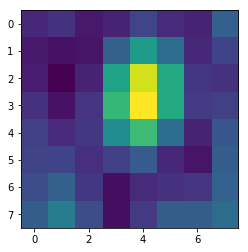

In [15]:
from scipy.fftpack import idctn
q1 = data["DQT"][0]["tables"][0]["matrix"]
q2 = data["DQT"][0]["tables"][1]["matrix"]

a = np.array([[ 5,  2, 33,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

#add in difference from previous DC value

#entry-for-entry product with quantization matrix
a = np.multiply(a, q2)

#inverse DCT
a = idctn(a, norm="ortho")

#round all values
a = np.round(a)

#add 128 to all entries
img = a + 128

#clip values outside [0, 255]

test = np.array([[-416, -33, -60, 32, 48, -40, 0, 0],
                [0, -24, -56, 19, 26, 0, 0, 0],
                [-42, 13, 80, -24, -40, 0, 0, 0],
                [-42, 17, 44, -29, 0, 0, 0, 0],
                [18, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0]])
r = idctn(test, norm="ortho")
r = np.round(r)
r += 128
img = r.reshape(8,8)
print(img)
plt.imshow(img)

<module 'matplotlib.pyplot' from 'c:\\users\\skyle\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

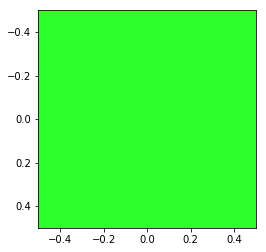

In [16]:
import matplotlib.pyplot as plt
img = [[[45,255,43]]]
plt.imshow(img)
plt